In [1]:
import pandas as pd
import numpy as np
import quandl
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas_datareader.data as web
from statsmodels.tsa.stattools import coint
import yfinance as yf

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Fetching data for AMD...
Data for AMD fetched successfully.
Fetching data for NVDA...
Data for NVDA fetched successfully.
Fetching data for INTC...
Data for INTC fetched successfully.
Fetching data for LRCX...
Data for LRCX fetched successfully.
Fetching data for TXN...
Data for TXN fetched successfully.
Fetching data for QCOM...
Data for QCOM fetched successfully.
Fetching data for MU...


Data for MU fetched successfully.
Data fetched successfully. Proceeding with cointegration test...
Cointegrated pairs found: [('TXN', 'MU')]

('TXN', 'MU'):

Mean Spread: 53.215716130537444
Standard Deviation of Spread: 5.901198372350227

               spread  High Spread  Low Spread
Date                                          
2016-01-04  40.010000            0           1
2016-01-05  38.950001            0           1
2016-01-06  39.199998            0           1
2016-01-07  38.040001            0           1
2016-01-08  37.030001            0           1
2016-01-11  38.679999            0           1
2016-01-12  38.809999            0           1
2016-01-13  37.759999            0           1
2016-01-14  38.009998            0           1
2016-01-15  36.949999            0           1
2016-01-19  37.420001            0           1
2016-01-20  38.959998            0           1
2016-01-21  38.980001            0           1
2016-01-22  39.230000            0           1
2016-01-2

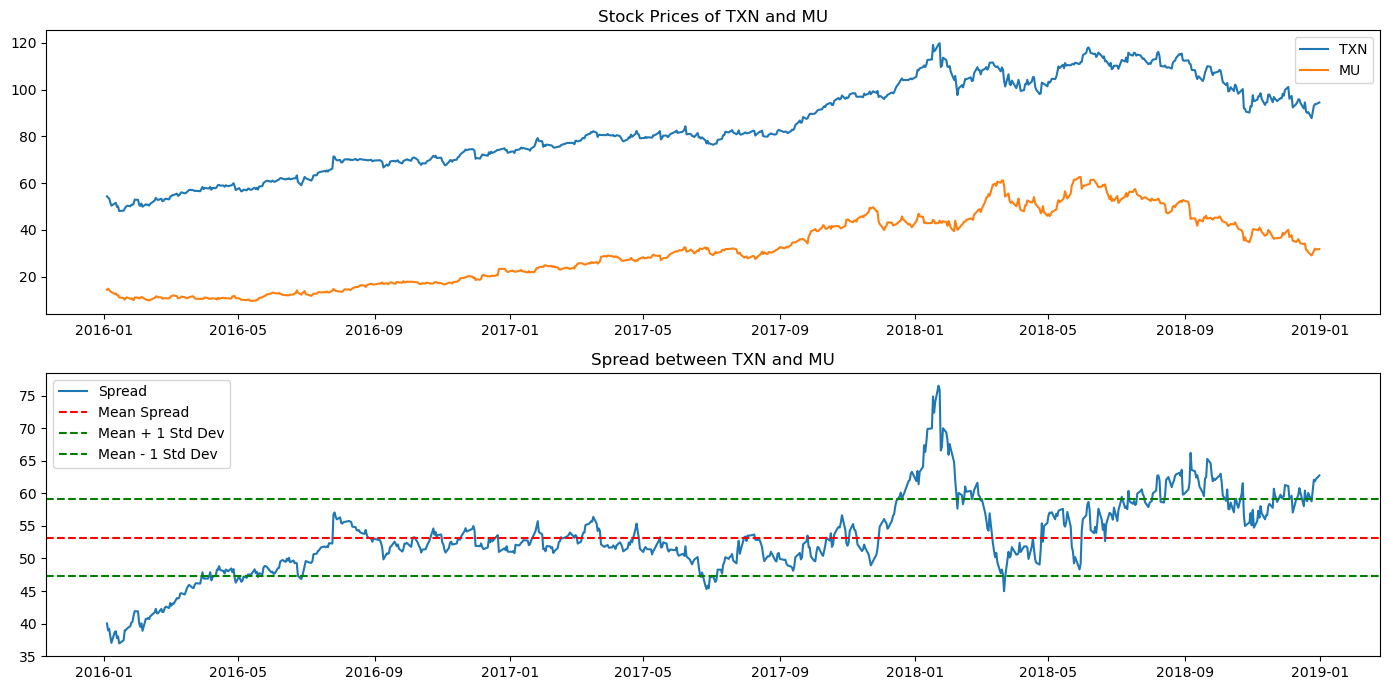

In [8]:
# Input your stock symbols
stocks = ['AMD', 'NVDA', 'INTC', 'LRCX', 'TXN', 'QCOM', 'MU']

# Setup dictionary to hold the data for each stock
data = {}

# Data for each stock from Yahoo Finance
for stock in stocks:
    print(f"Fetching data for {stock}...")
    df = yf.download(stock, start='2016-01-01', end='2019-01-01')
    if df.empty:
        print(f"No data for {stock}")
    else:
        data[stock] = df['Close']
        print(f"Data for {stock} fetched successfully.")

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)
df = df.dropna()

# Check if data is available
if df.empty:
    print("No data available for the specified tickers.")
else:
    print("Data fetched successfully. Proceeding with cointegration test...")

    # Function to find cointegrated pairs
    def find_cointegrated_pairs(data):
        n = data.shape[1]
        score_matrix = np.zeros((n, n))
        pvalue_matrix = np.ones((n, n))
        keys = data.keys()
        pairs = []
        for i in range(n):
            for j in range(i+1, n):
                S1 = data[keys[i]]
                S2 = data[keys[j]]
                result = coint(S1, S2)
                score = result[0]
                pvalue = result[1]
                score_matrix[i, j] = score
                pvalue_matrix[i, j] = pvalue
                if pvalue < 0.05:
                    pairs.append((keys[i], keys[j]))
        return score_matrix, pvalue_matrix, pairs

    # Find cointegrated pairs
    scores, pvalues, pairs = find_cointegrated_pairs(df)
    print(f"Cointegrated pairs found: {pairs}")

    # For each cointegrated pair
    for pair in pairs:
        # Calculate the spread
        df['spread'] = df[pair[0]] - df[pair[1]]
        
        # Calculate the mean and standard deviation of the spread for each pair
        mean_spread = df['spread'].mean()
        std_spread = df['spread'].std()
        
        # Create an indicator for when the spread is high (above 1 standard deviation from the mean)
        df['High Spread'] = np.where(df['spread'] > mean_spread + std_spread, 1, 0)
        
        # Create an indicator for when the spread is low (below 1 standard deviation from the mean)
        df['Low Spread'] = np.where(df['spread'] < mean_spread - std_spread, 1, 0)
        
        # Print the results
        print(f'\n{pair}:\n')
        print(f'Mean Spread: {mean_spread}')
        print(f'Standard Deviation of Spread: {std_spread}\n')
        print(df[['spread', 'High Spread', 'Low Spread']].head(25))
        
        # Plot the stock prices and the spread
        plt.figure(figsize=(14, 7))
        
        # Plot stock prices
        plt.subplot(2, 1, 1)
        plt.plot(df[pair[0]], label=pair[0])
        plt.plot(df[pair[1]], label=pair[1])
        plt.title(f'Stock Prices of {pair[0]} and {pair[1]}')
        plt.legend()
        
        # Plot the spread
        plt.subplot(2, 1, 2)
        plt.plot(df['spread'], label='Spread')
        plt.axhline(mean_spread, color='red', linestyle='--', label='Mean Spread')
        plt.axhline(mean_spread + std_spread, color='green', linestyle='--', label='Mean + 1 Std Dev')
        plt.axhline(mean_spread - std_spread, color='green', linestyle='--', label='Mean - 1 Std Dev')
        plt.title(f'Spread between {pair[0]} and {pair[1]}')
        plt.legend()
        
        plt.tight_layout()
        plt.show()